<a href="https://colab.research.google.com/github/Kvitatiani/dimensionality_reduction/blob/main/dimensionality_reduction_banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Data Load

**About the dataset**:

   This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).
   The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.
   This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns).

Attribute Information

- **Bank client data**:
  1. age  
  2. job: type ("admin.","blue-collar", etc.)  
  3. marital: marital status ("divorced","married","single","unknown")  
  4. education: ("basic.4y","high.school","university.degree", etc.)  
  5. default: credit in default? ("no","yes","unknown")  
  6. housing: housing loan? ("no","yes","unknown")  
  7. loan: personal loan? ("no","yes","unknown")  

- **Last contact of current campaign**:
  8. contact: type ("cellular","telephone")  
  9. month: last contact month ("jan","feb", etc.)  
  10. day_of_week: last contact day ("mon","tue", etc.)  
  11. duration: last contact duration in seconds (important for benchmarking only)  

- **Campaign data**:
  12. campaign: contacts in this campaign  
  13. pdays: days since last contact from previous campaign (999 = not contacted)  
  14. previous: contacts before this campaign  
  15. poutcome: previous campaign outcome ("failure","nonexistent","success")  

- **Social/economic context**:
  16. emp.var.rate: employment variation rate  
  17. cons.price.idx: consumer price index  
  18. cons.conf.idx: consumer confidence index  
  19. euribor3m: euribor 3-month rate  
  20. nr.employed: number of employees  

- **Output variable**:
  21. y - has the client subscribed a term deposit? ("yes","no")

In [ ]:
# for connecting to endpoint
import requests
#for unzipping file
import zipfile
import os

# DS Libraries
import pandas as pd
import numpy as np
from scipy.stats import stats, chi2_contingency
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='bright' )

In [ ]:
dataset_url = "https://static.cdn.epam.com/uploads/583f9e4a37492715074c531dbd5abad2/ds/data.%20module%201.%20EDA.zip"
zip_path = "/content/data. module 1. EDA"

In [ ]:
response = requests.get(dataset_url)
with open(zip_path, "wb") as file:
  file.write(response.content)

In [ ]:
extracted_folder_path = "/content/m1_dataset"
if not os.path.exists(extracted_folder_path):
  os.makedirs(extracted_folder_path)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall(extracted_folder_path)

In [ ]:
extracted_folder = os.listdir(extracted_folder_path)
print("Extracted folder: ", extracted_folder)
dataset_path = f"{extracted_folder_path}/{extracted_folder[0]}/bank-additional-full.csv"
print(dataset_path)

Extracted folder:  ['data. module 1. EDA']
/content/m1_dataset/data. module 1. EDA/bank-additional-full.csv


In [ ]:
# finally, load indo pandas df
df = pd.read_csv(dataset_path, delimiter=";")

# Define Functions

In [ ]:
# outliers capping function
def cap_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3-Q1
  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR
  df[column] = df[column].apply(lambda x: lower_limit if x < lower_limit else upper_limit if x > upper_limit else x)

# Cramer's V function
def cramer_v(cross_table):
    chi2, p, dof, expected = chi2_contingency(cross_table)
    n = np.sum(cross_table.values)
    phi2 = chi2 / n
    r, c = cross_table.shape
    return np.sqrt(phi2 / min(r - 1, c - 1))

# EDA


### Basic inspection of data

In [ ]:
df.head(5).T

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp.var.rate            1.1          1.1          1.1          1.1   
cons.price.idx       93.994       93.994       93.994       93.994   
cons.conf.idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr.employed          5191.0       5191.0       5191.0       5191.0   
y                        no           no           no           no   

                          4  
age                      56  
job                services  
marital             married  
education       high.school  
default                  no  
housing                  no  
loan                    yes  
contact           telephone  
month                   may  
day_of_week             mon  
duration                307  
campaign                  1  
pdays                   999  
previous                  0  
poutcome        nonexistent  
emp.var.rate            1.1  
cons.price.idx       93.994  
cons.conf.idx         -36.4  
euribor3m             4.857  
nr.employed          5191.0  
y                        no

In [ ]:
df.shape

(41188, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**check for missing values**

In [ ]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## Univariate Analysis

### Numerical Variables

**Descriptive stats**

In [ ]:
df.describe().T

count         mean         std       min       25%  \
age             41188.0    40.024060   10.421250    17.000    32.000   
duration        41188.0   258.285010  259.279249     0.000   102.000   
campaign        41188.0     2.567593    2.770014     1.000     1.000   
pdays           41188.0   962.475454  186.910907     0.000   999.000   
previous        41188.0     0.172963    0.494901     0.000     0.000   
emp.var.rate    41188.0     0.081886    1.570960    -3.400    -1.800   
cons.price.idx  41188.0    93.575664    0.578840    92.201    93.075   
cons.conf.idx   41188.0   -40.502600    4.628198   -50.800   -42.700   
euribor3m       41188.0     3.621291    1.734447     0.634     1.344   
nr.employed     41188.0  5167.035911   72.251528  4963.600  5099.100   

                     50%       75%       max  
age               38.000    47.000    98.000  
duration         180.000   319.000  4918.000  
campaign           2.000     3.000    56.000  
pdays            999.000   999.000   999.000  
previous           0.000     0.000     7.000  
emp.var.rate       1.100     1.400     1.400  
cons.price.idx    93.749    93.994    94.767  
cons.conf.idx    -41.800   -36.400   -26.900  
euribor3m          4.857     4.961     5.045  
nr.employed     5191.000  5228.100  5228.100

We can already see that numeric columns like duration, campaign, pdays and previous show signs of extreme outliers and anomalies, let's dive deeper

In [ ]:
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3-Q1
print(f"Q1 is equal to {Q1}, Q3 to {Q3} and finally interquantile range is {IQR}")

Q1 is equal to 102.0, Q3 to 319.0 and finally interquantile range is 217.0


let's define outlier limits

In [ ]:
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# values outside of limit

duration_outliers_count = df.duration[(df['duration'] <= lower_limit) |  (df['duration'] >= upper_limit) ].count()

seems like a lot of outliers, lets check the % of total

In [ ]:
print(f"outliers in 'duration' column consist {duration_outliers_count/df.shape[0]*100:.2f}% of total counts ")

outliers in 'duration' column consist 7.19% of total counts 


log transformation in this case seems like a good idea. We'll deal with it later

In [ ]:
df['campaign'].describe()

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

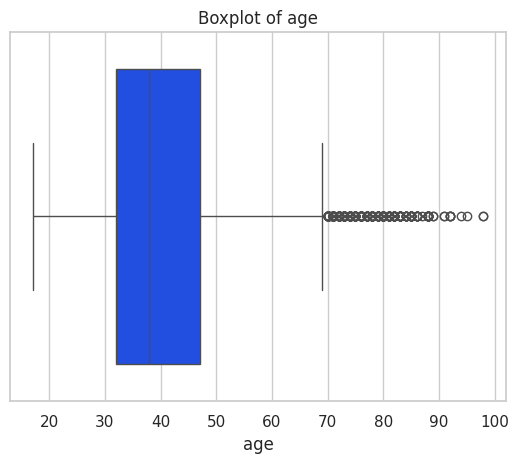

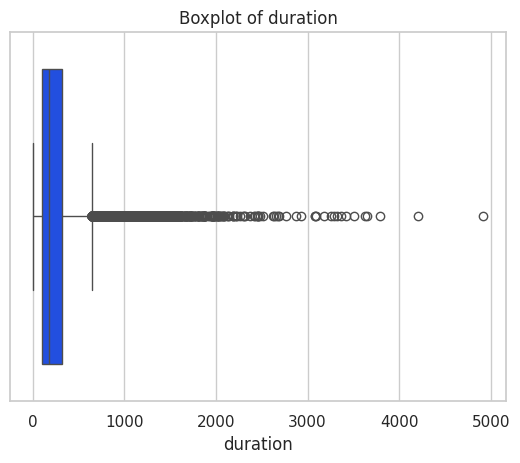

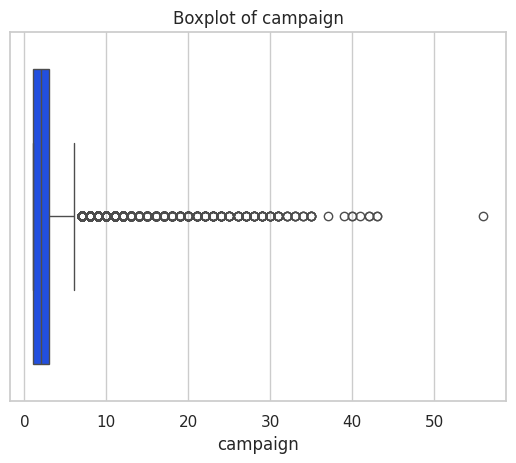

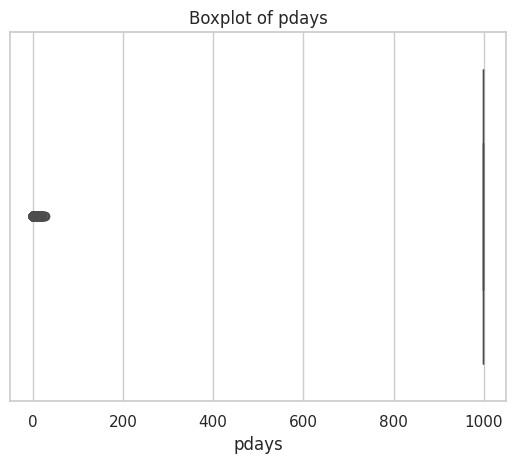

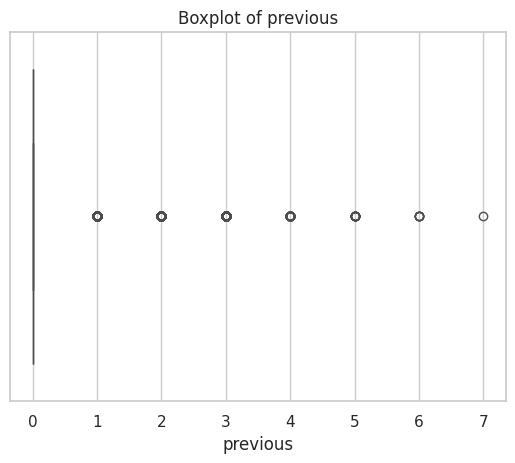

In [ ]:
dubious_subset = df[['age','duration','campaign', 'pdays', 'previous']]
# Boxplot for duration
# sns.boxplot(x='duration', data=df)
# plt.title('Boxplot of Duration')
# plt.show()

for column in dubious_subset:
  sns.boxplot(x=f'{column}', data=df)
  plt.title(f'Boxplot of {column}')
  plt.show()

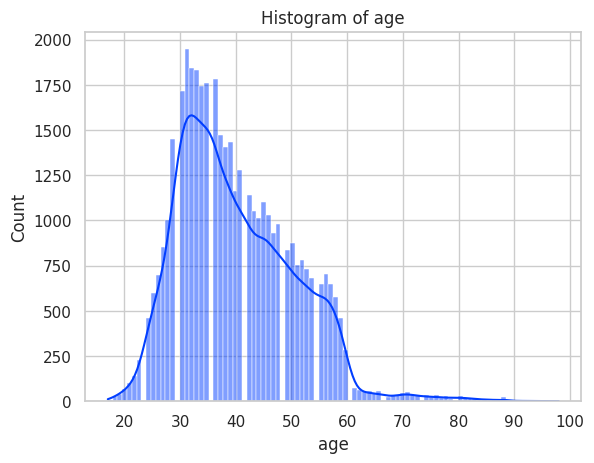

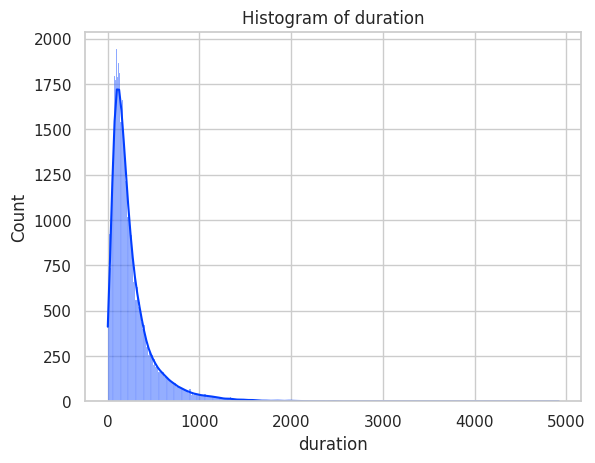

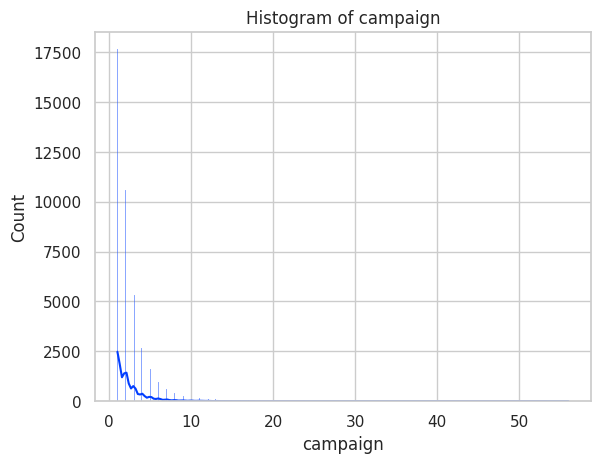

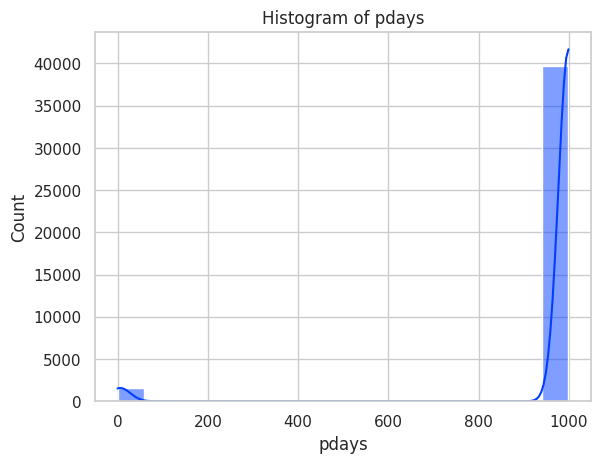

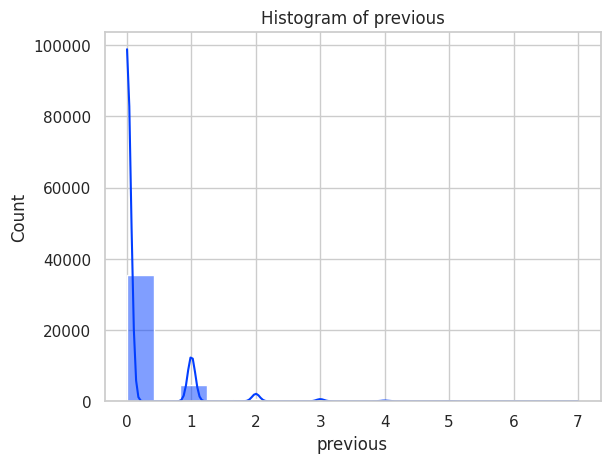

In [ ]:
for column in dubious_subset:
  sns.histplot(x=f'{column}', data=df, kde=True)
  plt.title(f'Histogram of {column}')
  plt.show()

**From the plots it's obvious that: 1. 'duration' and 'campaign' have extreme outliers, which is expected 2. we need to do something about pdays column, which is using '999' as kind of like a categorical indicator that client hasn't been contacted before**

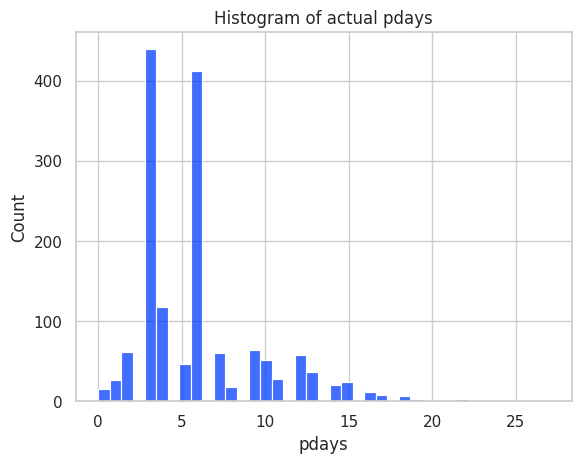

In [ ]:
subset_pdays = df[df['pdays']!=999]
sns.histplot(x='pdays', data=subset_pdays)
plt.title('Histogram of actual pdays')
plt.show()

**We can now see that actual number of days since last contact is somewhere between 0 and 30 days and moreover last campaign only recently finished. It's interesting to see what's the actual maximum number of days since last contact. Moreover we should consider the following for later: maybe use pdays variable to create new variable "whether client was contacted during last campaign or not" boolean type. I shall address this in DP**

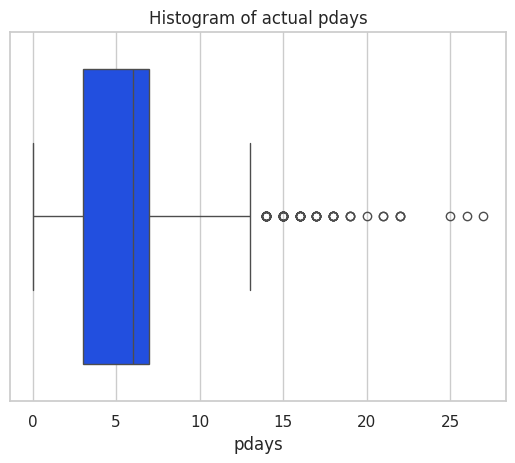

In [ ]:
subset_pdays['pdays'].max()
#let's also see this in boxplot
sns.boxplot(x='pdays', data=subset_pdays)
plt.title('Histogram of actual pdays')
plt.show()
# definitely a much clearer picture.

In [ ]:
df.previous.value_counts()
print(f"{df.previous.value_counts()[0]} clients have not been contacted before this campaign!")
contact_y_relationship = df.groupby('previous')['y'].value_counts(normalize=True).unstack()
print(contact_y_relationship)

35563 clients have not been contacted before this campaign!
y               no       yes
previous                    
0         0.911678  0.088322
1         0.787985  0.212015
2         0.535809  0.464191
3         0.407407  0.592593
4         0.457143  0.542857
5         0.277778  0.722222
6         0.400000  0.600000
7         1.000000       NaN


**Let's have a look at economic variables and their distributions**

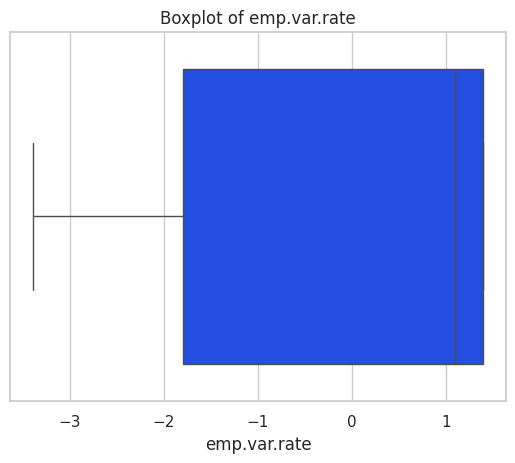

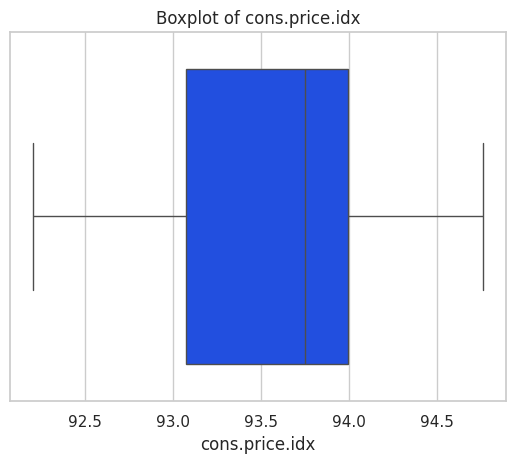

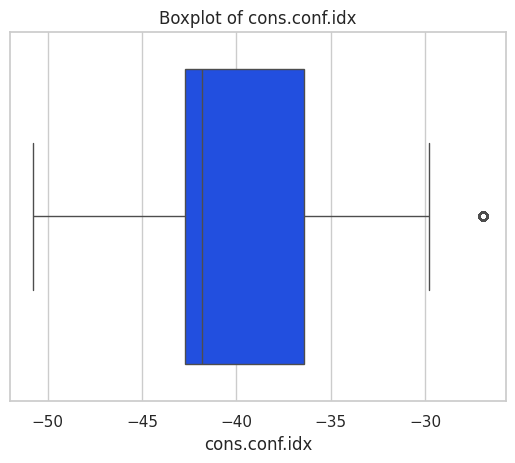

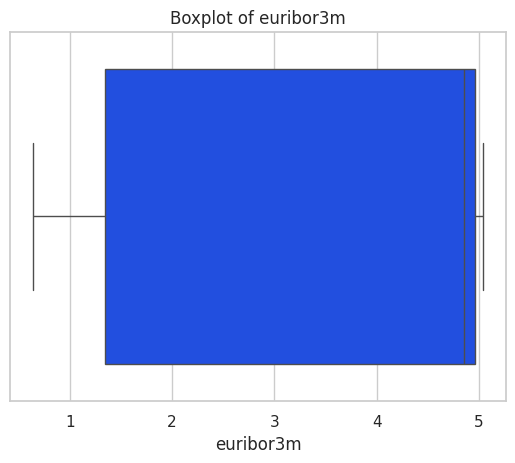

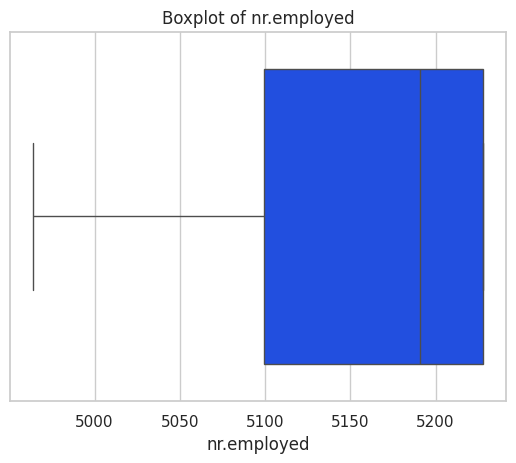

In [ ]:
economic_variables = df[['emp.var.rate','cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed' ]]
for col in economic_variables:
  sns.boxplot(x=col, data=economic_variables)
  plt.title(f"Boxplot of {col}")
  plt.show()

As expected, data in economic indices are much less volatile and there are virtually no outliers, except for an outlier in consumer confidence index. It will be interesting to see how that downturn on the market affects the conversion rate of the bank. But that might be topic for another project..

### Categorical Variables

In [ ]:
categorical_variables = df.select_dtypes(include='object')
categorical_variables.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

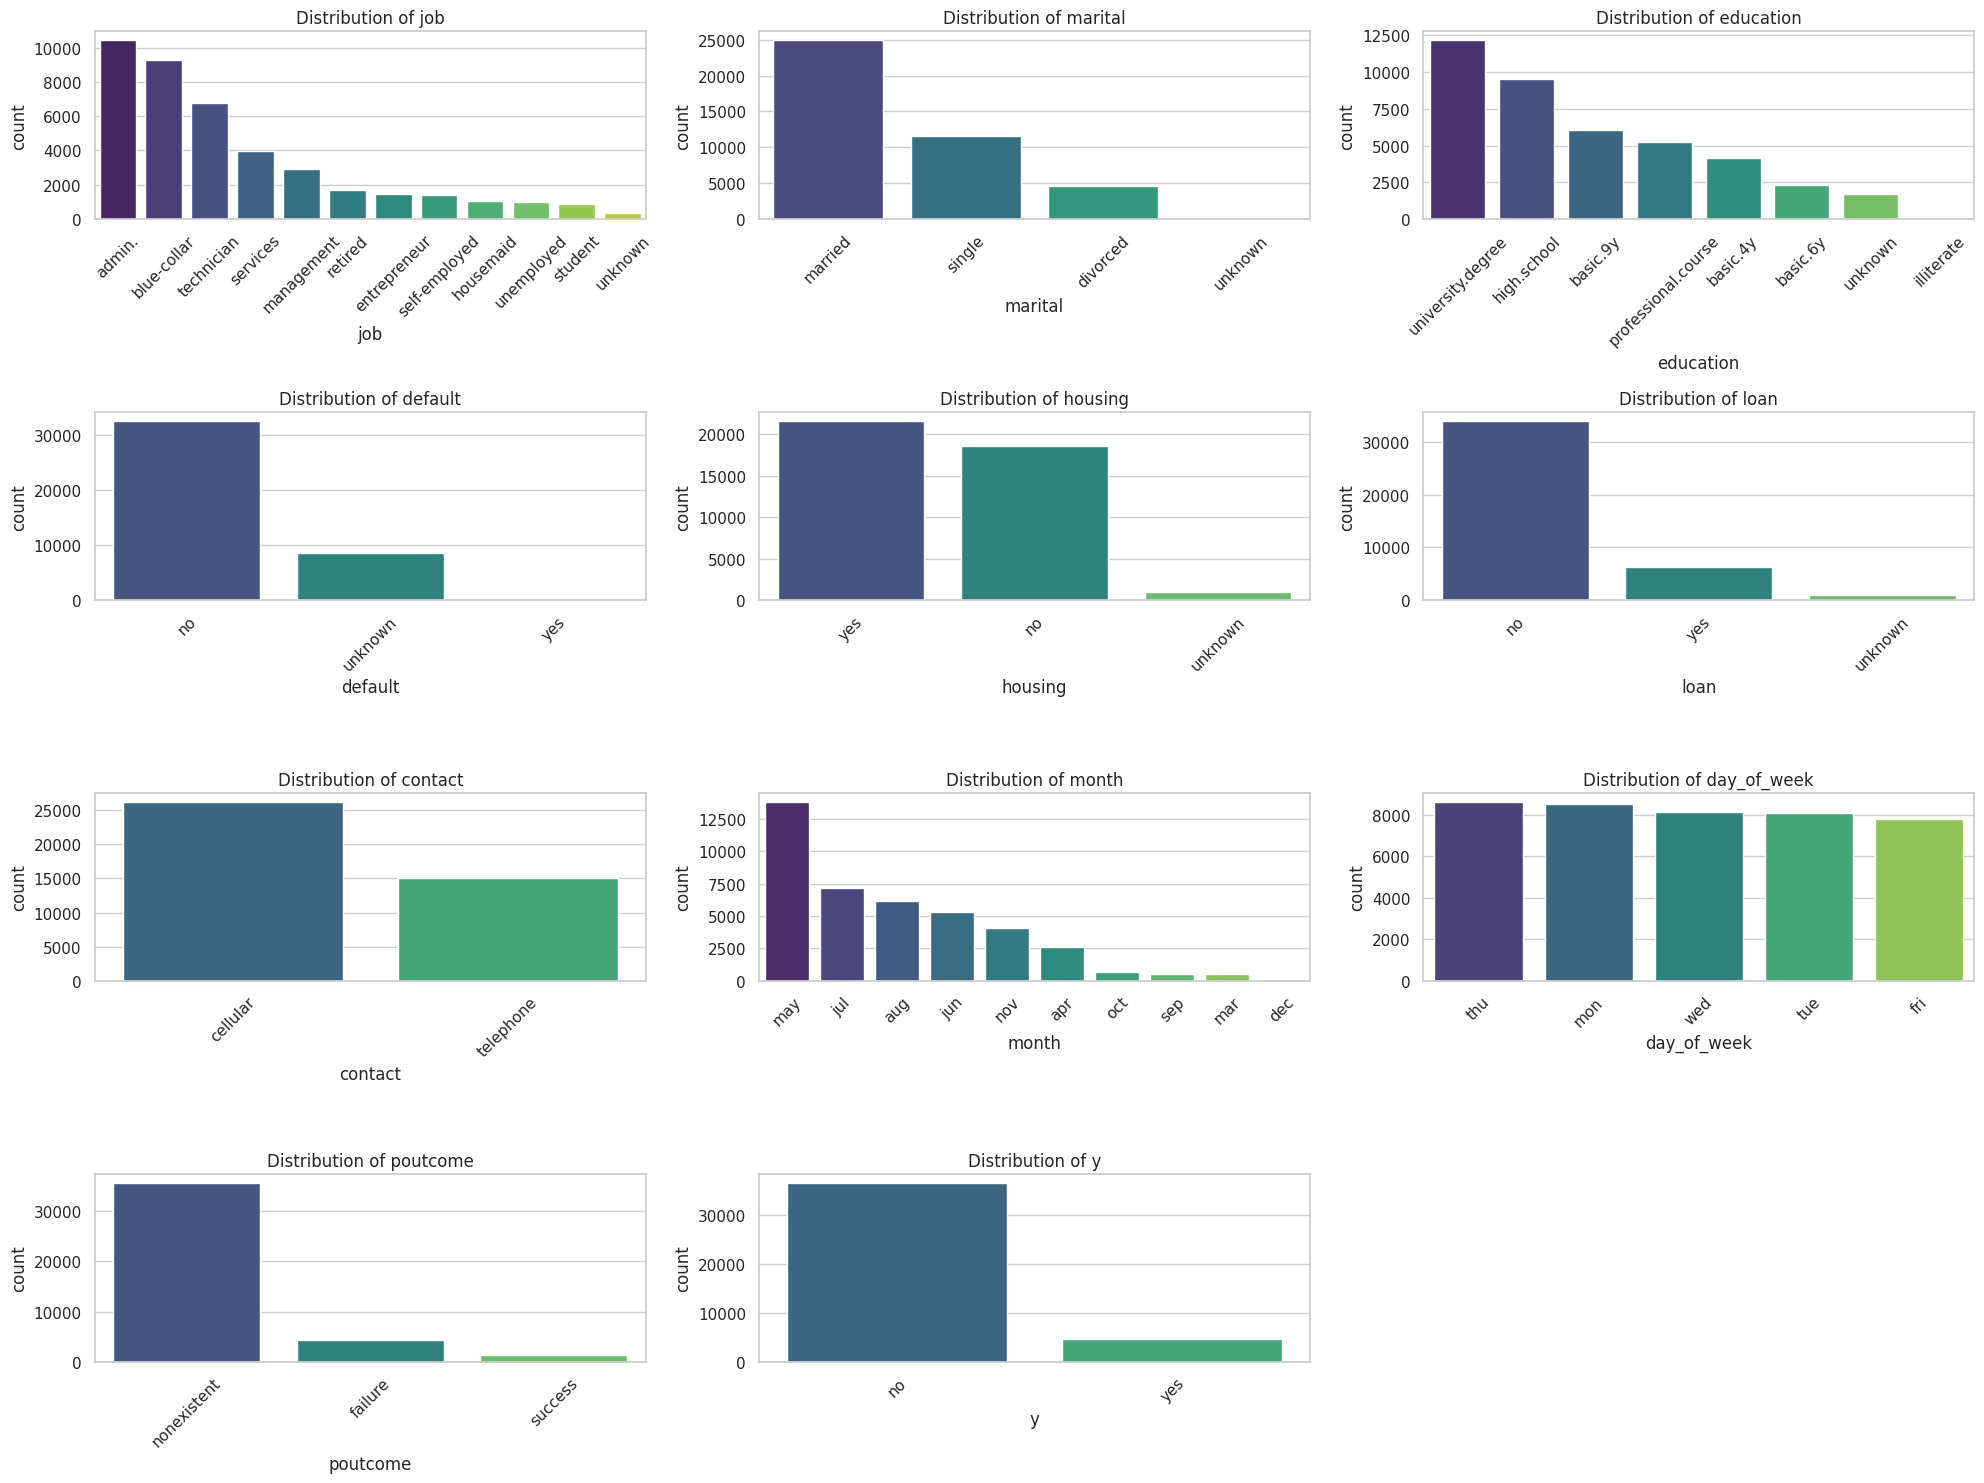

In [ ]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_variables.columns):
  value_counts = df[col].value_counts().reset_index()
  value_counts.columns = [col, 'count']

  plt.subplot((len(categorical_variables.columns)+2) // 3, 3, i+1)
  sns.barplot(x=col, y='count',hue=col,data=value_counts, dodge=False, palette='viridis', legend=False)
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45)
  plt.xlabel(col)
  plt.ylabel('count')

plt.tight_layout()
plt.show()

In [ ]:
df.poutcome.value_counts()

poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

**1. We might need to deal with unknown/nonexistent values in default, housing, loan. 2. poutcome's nonexistent values should equal to 0s in previous**

In [ ]:
len(df[df['previous']==0])

35563

**it seems I was right about 'previous' variable. Moreover, previous should be related to poutcome in the same manner as campaign to y, it's interesting to see this in correlations**

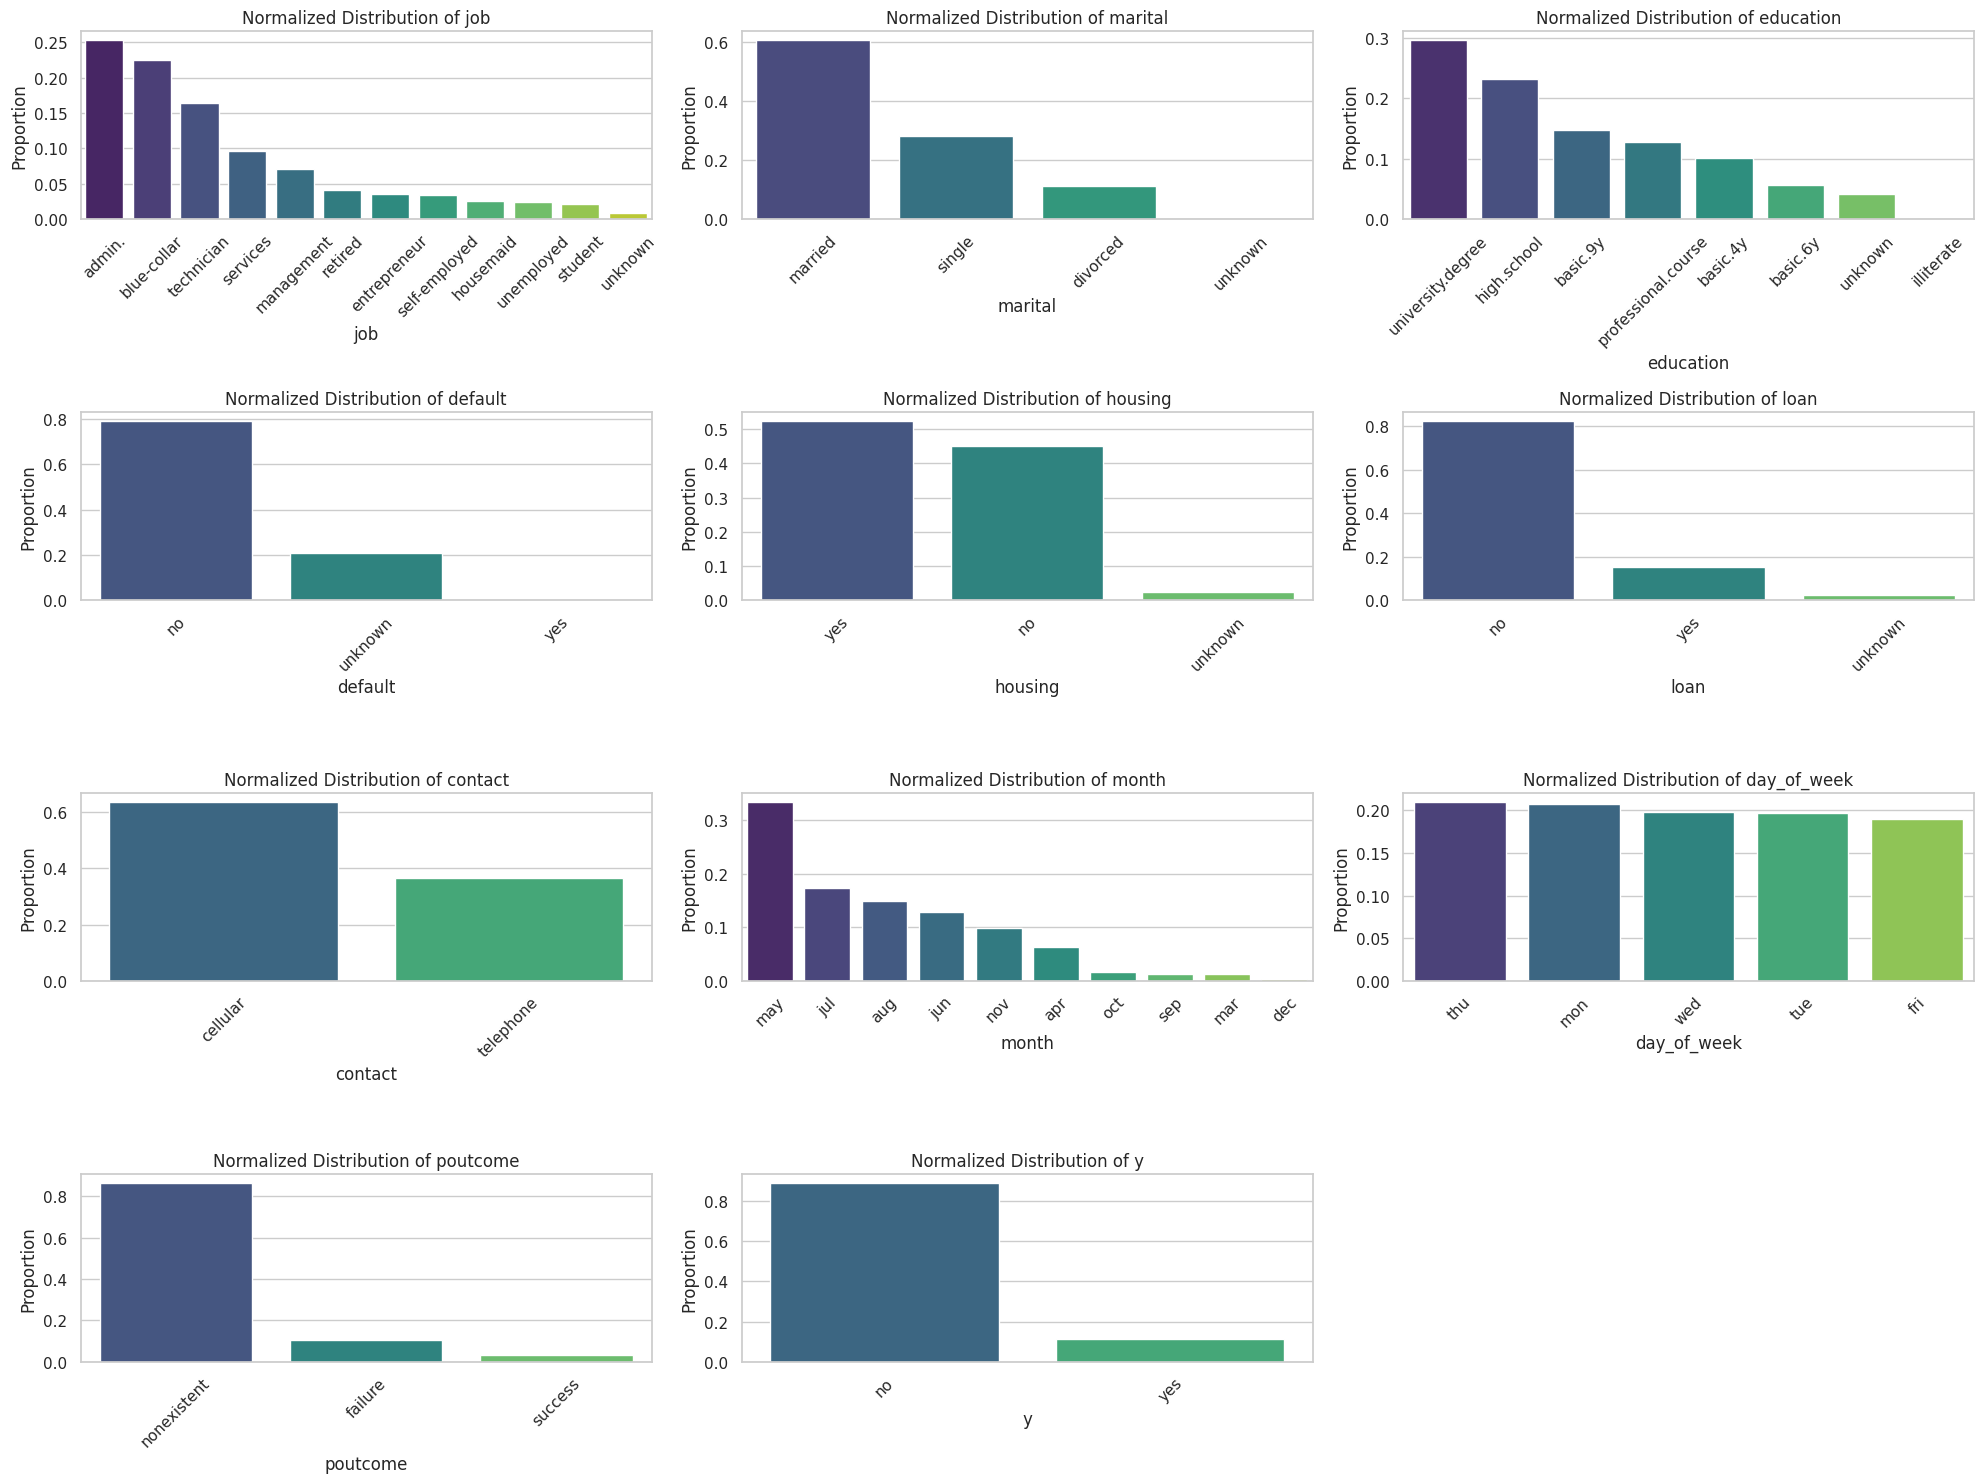

In [ ]:
# normalized version

plt.figure(figsize=(20, 15))


for i, col in enumerate(categorical_variables.columns):

    value_counts = df[col].value_counts(normalize=True).reset_index()
    value_counts.columns = [col, 'proportion']


    plt.subplot((len(categorical_variables.columns) + 2) // 3, 3, i + 1)
    sns.barplot(x=col, y='proportion', hue=col, data=value_counts, dodge=False, palette='viridis', legend=False)
    plt.title(f'Normalized Distribution of {col}')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

Let' see if we have to impute some of the unknown values

In [ ]:
subset_1 = categorical_variables[['marital', 'education', 'default', 'month', 'loan']]
[subset_1[col].value_counts() for col in subset_1.columns]
# almost no values for some of the sub-categories of categorical variables.

[marital
 married     24928
 single      11568
 divorced     4612
 unknown        80
 Name: count, dtype: int64,
 education
 university.degree      12168
 high.school             9515
 basic.9y                6045
 professional.course     5243
 basic.4y                4176
 basic.6y                2292
 unknown                 1731
 illiterate                18
 Name: count, dtype: int64,
 default
 no         32588
 unknown     8597
 yes            3
 Name: count, dtype: int64,
 month
 may    13769
 jul     7174
 aug     6178
 jun     5318
 nov     4101
 apr     2632
 oct      718
 sep      570
 mar      546
 dec      182
 Name: count, dtype: int64,
 loan
 no         33950
 yes         6248
 unknown      990
 Name: count, dtype: int64]

I should check the correlations, but by the first look I can leave "unknown" as a separate class without imputing

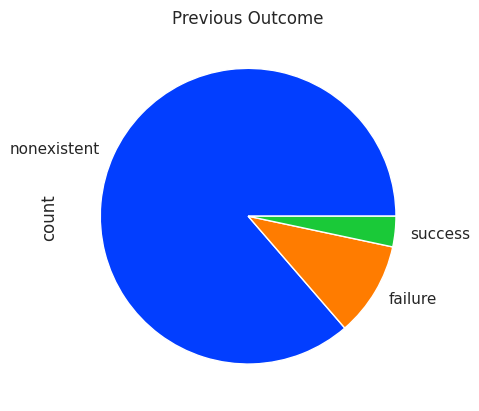

In [ ]:
df.poutcome.value_counts().plot.pie()
plt.title('Previous Outcome')
plt.show()

## Bivariate Analysis

### Numeric Variables

In [ ]:
# convert "y" variable to binary
df['y_numeric'] = df['y'].map({'yes':1,'no':0})
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  pdays  previous     poutcome  emp.var.rate  \
0   may         mon  ...    999         0  nonexistent           1.1   
1   may         mon  ...    999         0  nonexistent           1.1   
2   may         mon  ...    999         0  nonexistent           1.1   
3   may         mon  ...    999         0  nonexistent           1.1   
4   may         mon  ...    999         0  nonexistent           1.1   

  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  y_numeric  
0         93.994          -36.4      4.857       5191.0  no          0  
1         93.994          -36.4      4.857       5191.0  no          0  
2         93.994          -36.4      4.857       5191.0  no          0  
3         93.994          -36.4      4.857       5191.0  no          0  
4         93.994          -36.4      4.857       5191.0  no          0  

[5 rows x 22 columns]

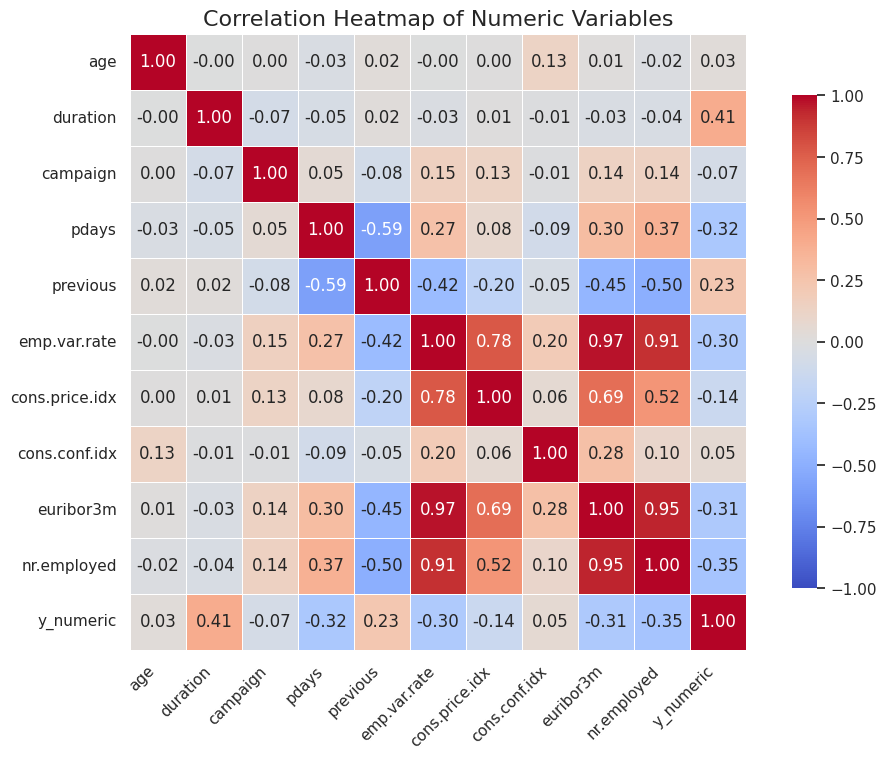

In [ ]:
numeric_variables = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_variables.corr()

plt.figure(figsize=(12,8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Heatmap of Numeric Variables", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.show()

As expected economical variables are highly correlated with each other, we might want to build a separate heatmap for them

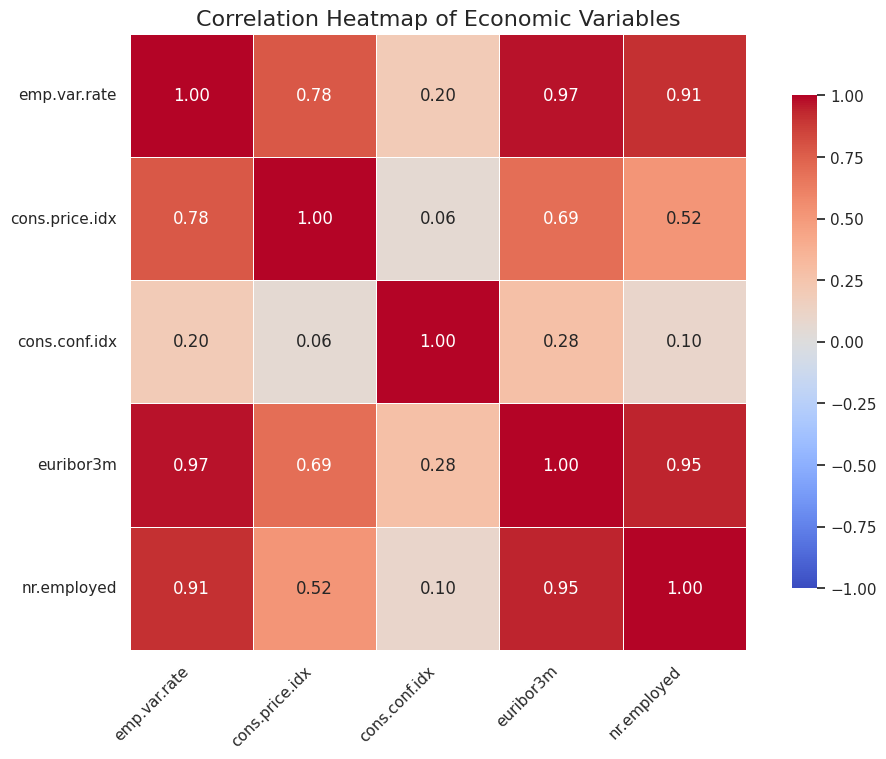

In [ ]:
# heatmap for economic variables
correlation_matrix = economic_variables.corr()

plt.figure(figsize=(12,8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Heatmap of Economic Variables", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.show()

**Heatmap suggests that emp.var.rate euribor3m and nr.employed are all highly correlated, we should consider dropping two of them later on. consumer price index is also correlated with those three. consumer confidence index seems to stand out and should be retained**

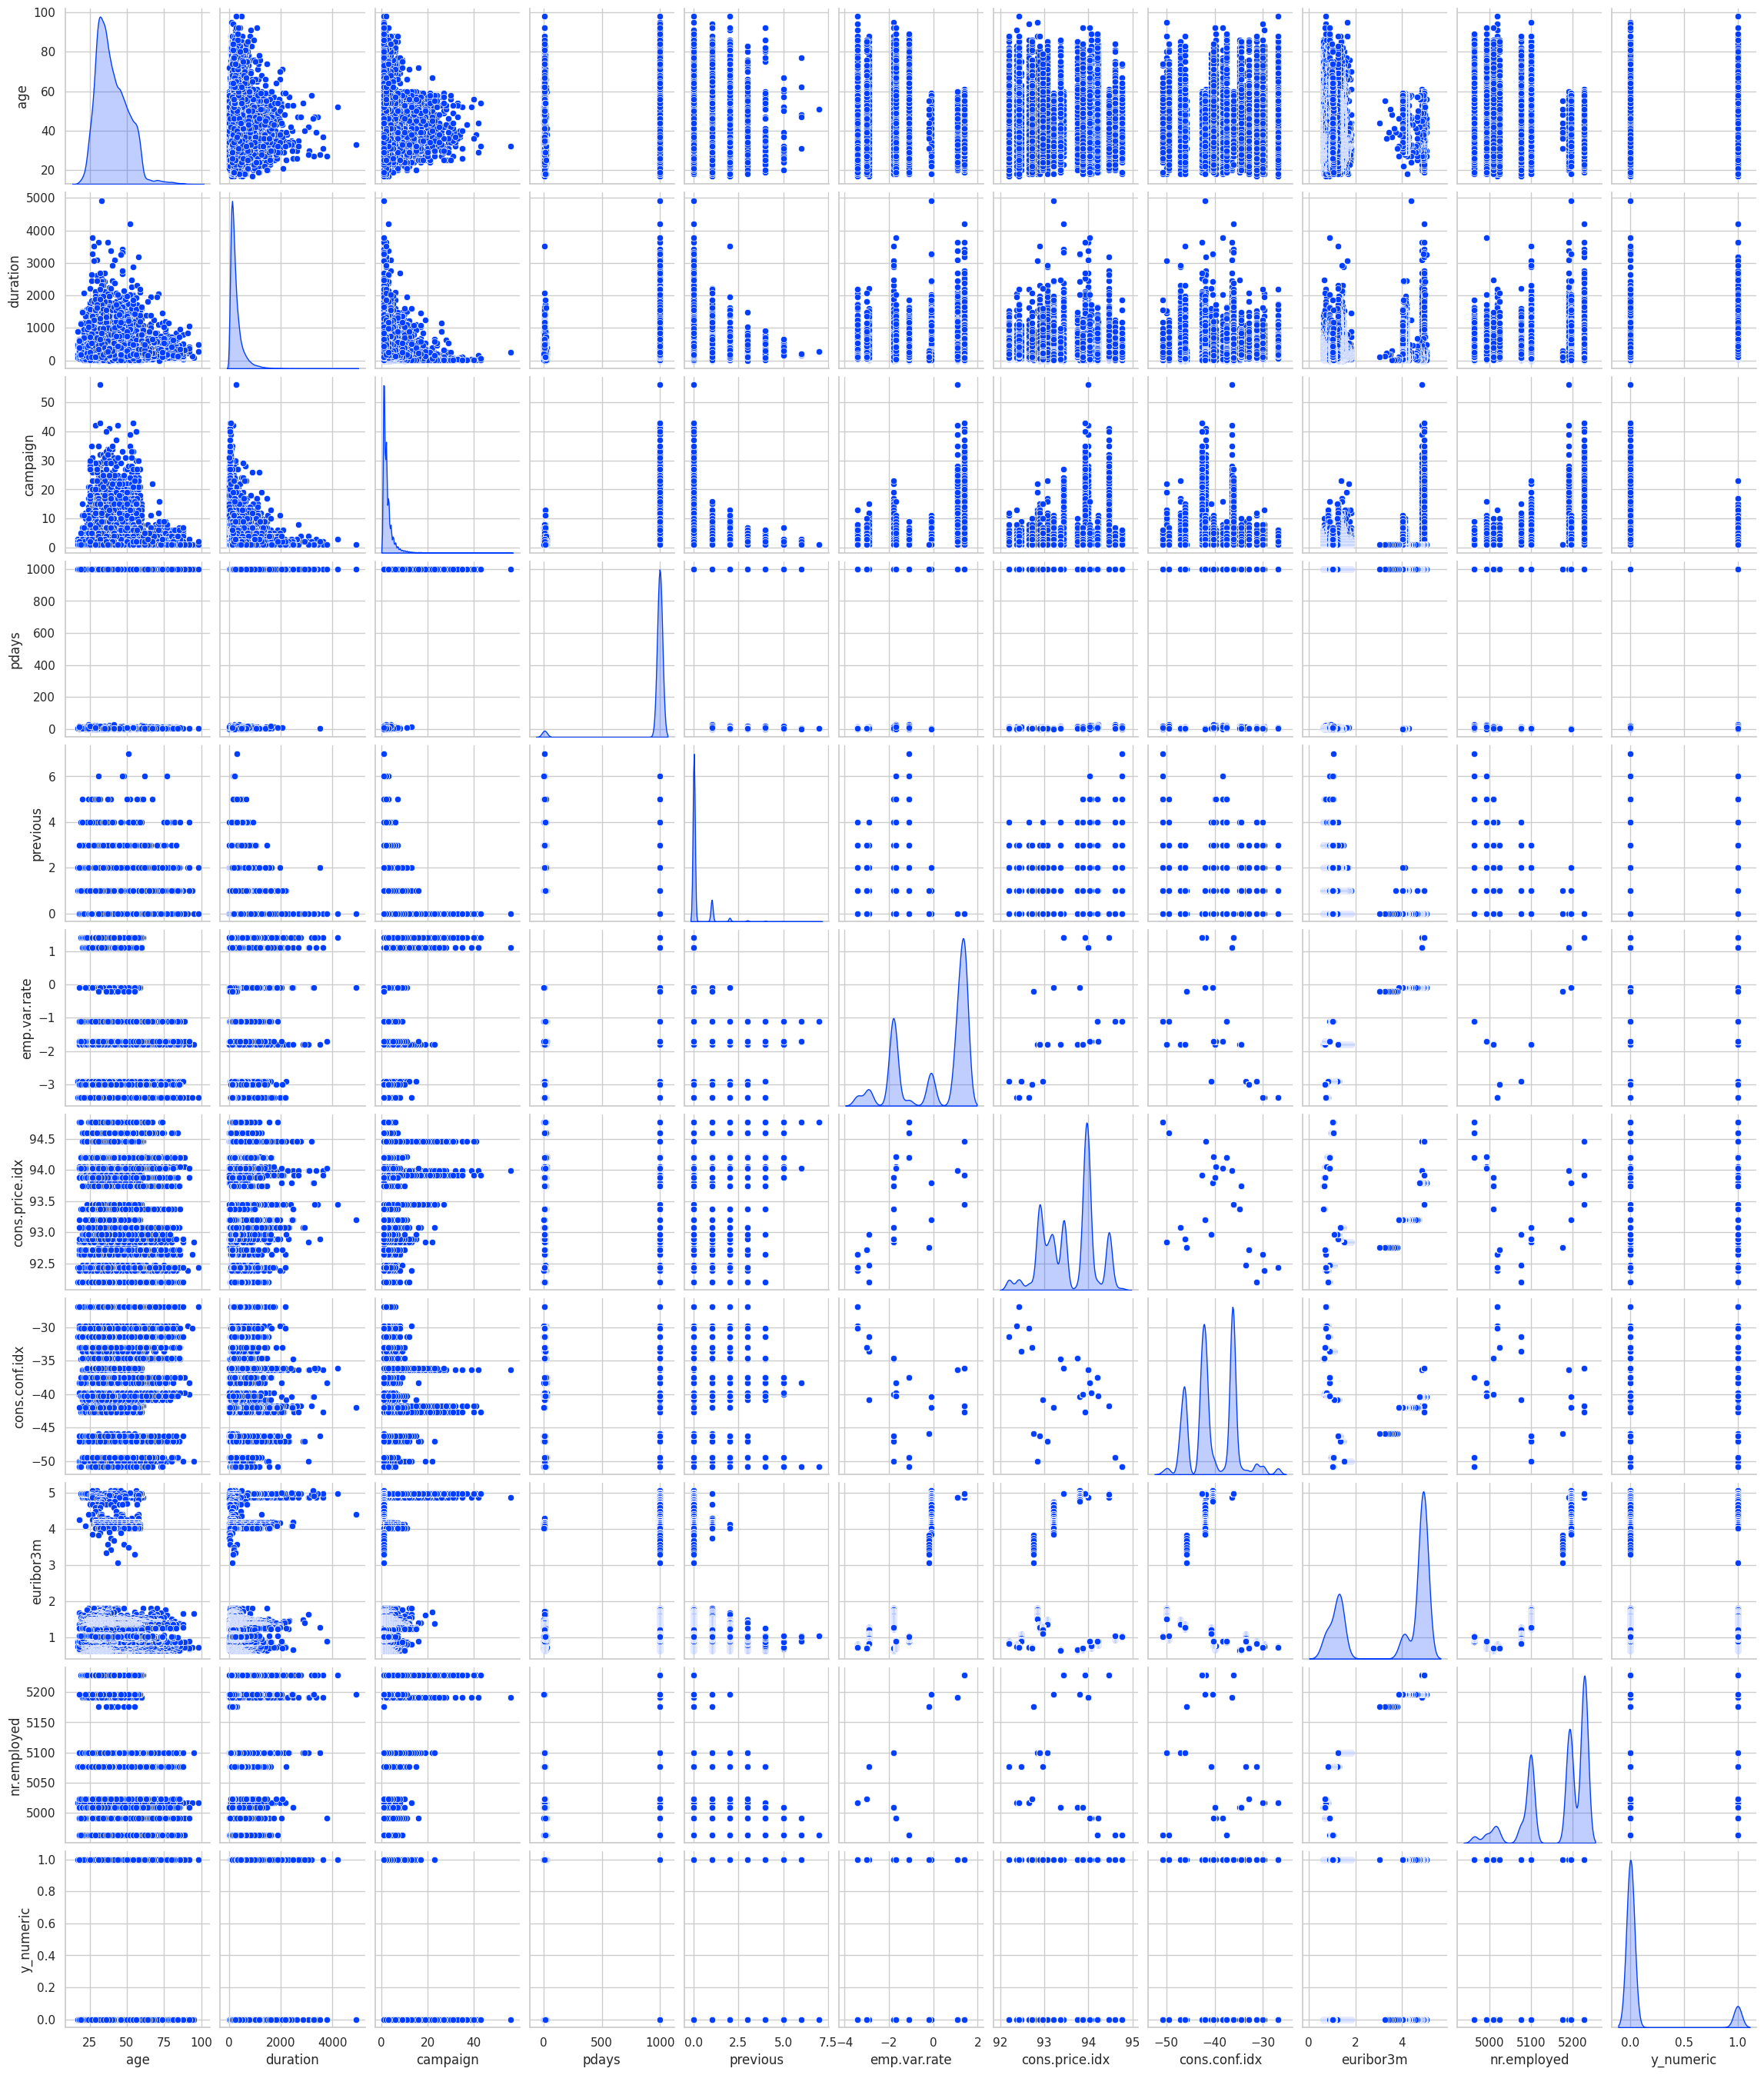

In [ ]:
sns.pairplot(
    data=numeric_variables,
    aspect=0.85,
    diag_kind='kde'
)
plt.show()

Let's analyze how call duration affects the outcome

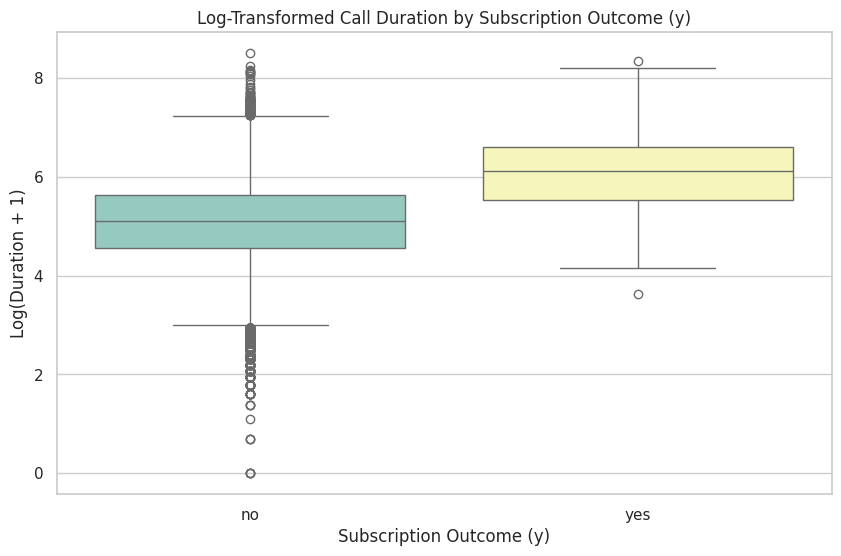

In [ ]:
df['log_duration'] = np.log1p(df['duration'])

plt.figure(figsize=(10,6))
sns.boxplot(x='y', y='log_duration', data=df, hue='y', palette='Set3', legend=False )
plt.title("Log-Transformed Call Duration by Subscription Outcome (y)")
plt.ylabel("Log(Duration + 1)")
plt.xlabel("Subscription Outcome (y)")
plt.show()

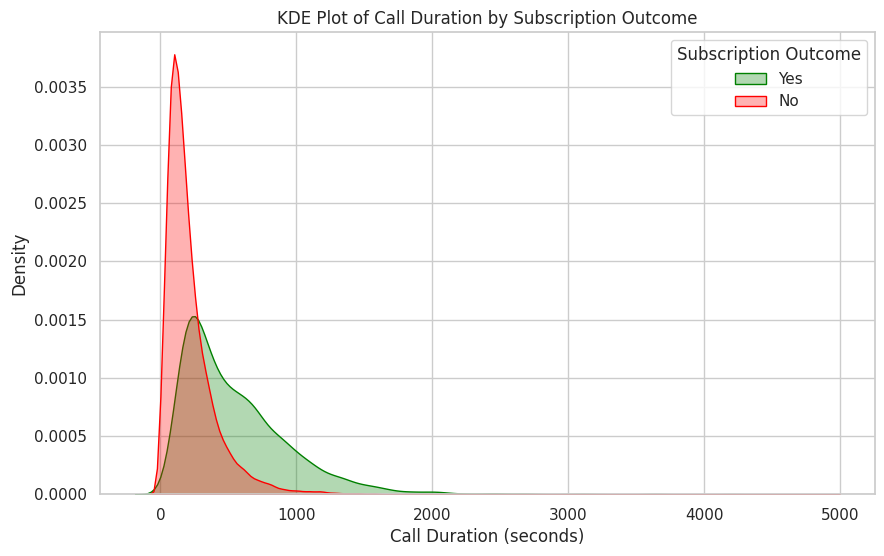

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['y'] == "yes"], x='duration', label='Yes', fill=True, color="green", alpha=0.3)
sns.kdeplot(data=df[df['y'] == "no"], x='duration', label='No', fill=True, color="red", alpha=0.3)
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Density")
plt.title("KDE Plot of Call Duration by Subscription Outcome")
plt.legend(title="Subscription Outcome")
plt.show()

In [ ]:
summary_stats = df.groupby('y')['duration'].agg(['mean', 'std', 'min', 'max', 'median', 'count'])
print(summary_stats)

           mean         std  min   max  median  count
y                                                    
no   220.844807  207.096293    0  4918   163.5  36548
yes  553.191164  401.171871   37  4199   449.0   4640


**As expected, clients who subscribed to termed-deposit had a longer conversaion with bank's sales representatives.That's also logical from domain knowledge, since clients who aren't interested in the product, try to hang up the call with salespeople more quickly, as conversation goes on, it's more likely that product sale will take place**

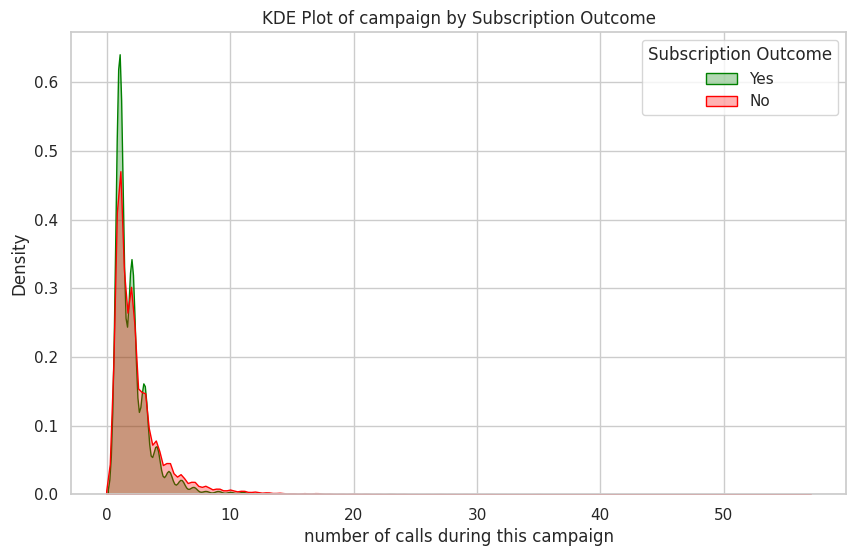

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['y'] == "yes"], x='campaign', label='Yes', fill=True, color="green", alpha=0.3)
sns.kdeplot(data=df[df['y'] == "no"], x='campaign', label='No', fill=True, color="red", alpha=0.3)
plt.xlabel("number of calls during this campaign")
plt.ylabel("Density")
plt.title("KDE Plot of campaign by Subscription Outcome")
plt.legend(title="Subscription Outcome")
plt.show()

### Categorical vs continuous

In [ ]:
# le = preprocessing.LabelEncoder()
# df['y_encoded'] = le.fit_transform(df['y'])
# df.drop(columns=['y_encoded'], inplace=True)
# instead of pearson, trying out pointbiserial per Mentor's advice when categorical vs numerical
print(stats.pointbiserialr(df['y_numeric'], df['euribor3m']))
print(stats.pointbiserialr(df['y_numeric'], df['emp.var.rate']))
print(stats.pointbiserialr(df['y_numeric'], df['nr.employed']))
print(stats.pointbiserialr(df['y_numeric'], df['cons.price.idx']))
print(stats.pointbiserialr(df['y_numeric'], df['cons.conf.idx']))

SignificanceResult(statistic=-0.3077714039407206, pvalue=0.0)
SignificanceResult(statistic=-0.29833442615937866, pvalue=0.0)
SignificanceResult(statistic=-0.35467829592143624, pvalue=0.0)
SignificanceResult(statistic=-0.13621121281924714, pvalue=9.318964779551726e-170)
SignificanceResult(statistic=0.0548779460531947, pvalue=7.536664996609495e-29)


<ipython-input-38-066e82a6c0c9>:5: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  print(stats.pointbiserialr(df['y_numeric'], df['euribor3m']))
<ipython-input-38-066e82a6c0c9>:6: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  print(stats.pointbiserialr(df['y_numeric'], df['emp.var.rate']))
<ipython-input-38-066e82a6c0c9>:7: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  print(stats.pointbiserialr(df['y_numeric'], df['nr.employed']))
<ipython-input-38-066e82a6c0c9>:8: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in 

actuall yields the same correlations as pearsons. Since nr.employed is the most correlated with target I might drop euribor3m and emp.var.rate in DP part

In [ ]:
temp_df = df.copy()
le = preprocessing.LabelEncoder()
temp_df = temp_df[temp_df['poutcome'] != "nonexistent"]
print(len(temp_df))
temp_df['poutcome_encoded'] = le.fit_transform(temp_df['poutcome'])
print(stats.pointbiserialr(temp_df['poutcome_encoded'], temp_df['previous']))

5625
SignificanceResult(statistic=0.26946813379511836, pvalue=3.545371773610042e-94)


<ipython-input-39-c61c5db7427c>:6: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  print(stats.pointbiserialr(temp_df['poutcome_encoded'], temp_df['previous']))


above, I wanted to see correlation between contacts during previous campaign and the previous outcome, it seems like there is a moderate positive correlation

### Categorical variables

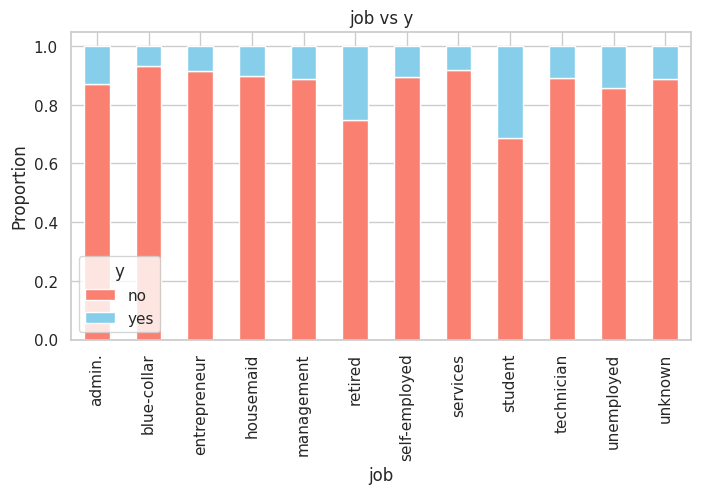

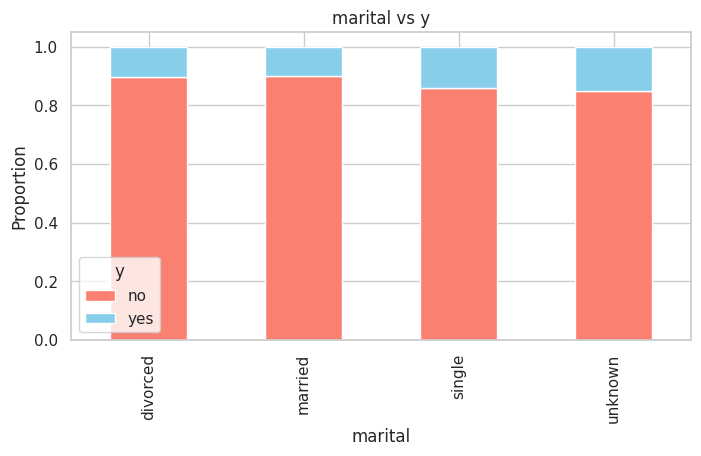

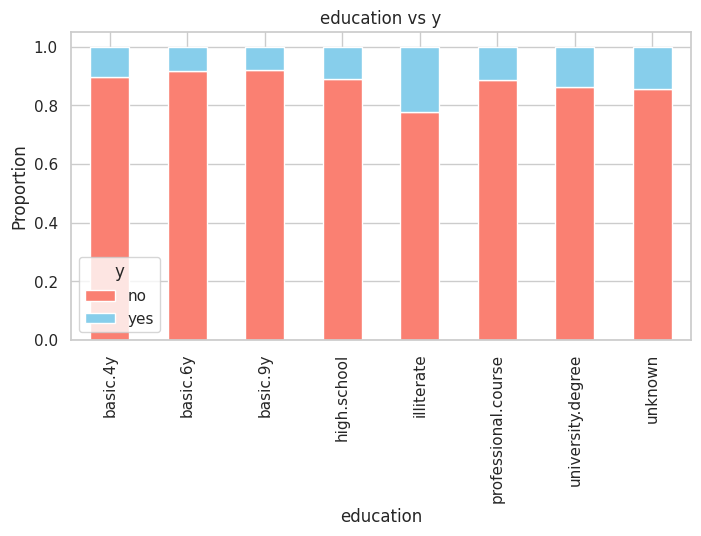

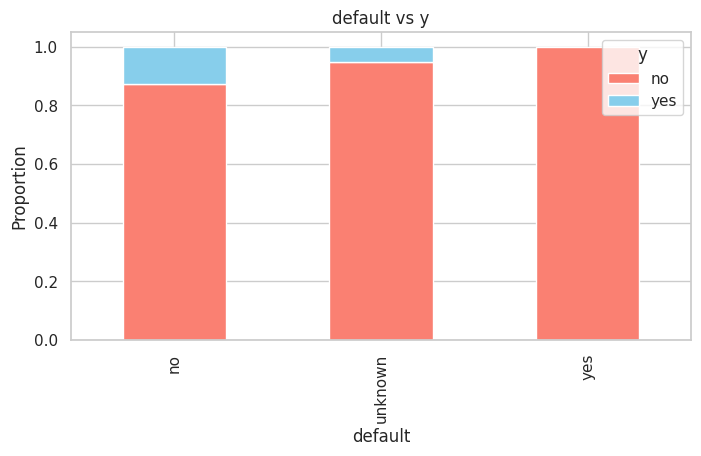

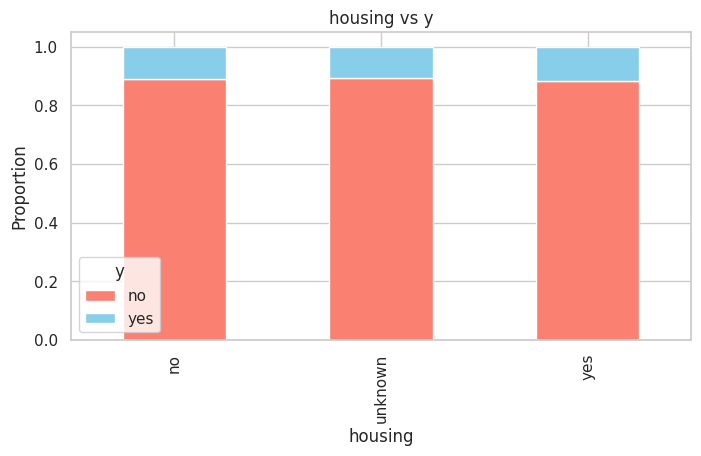

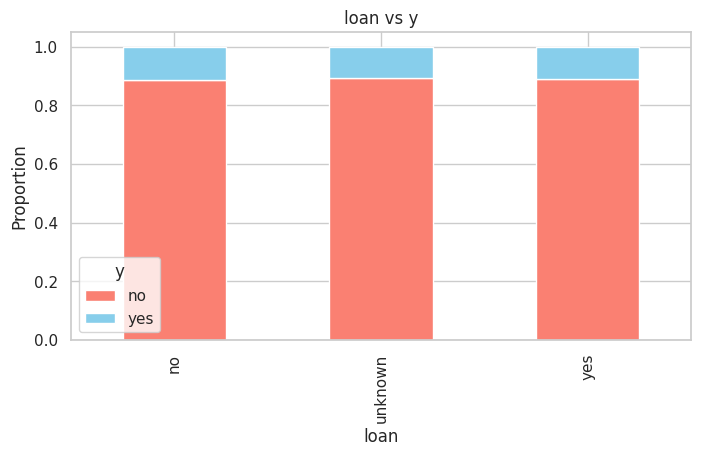

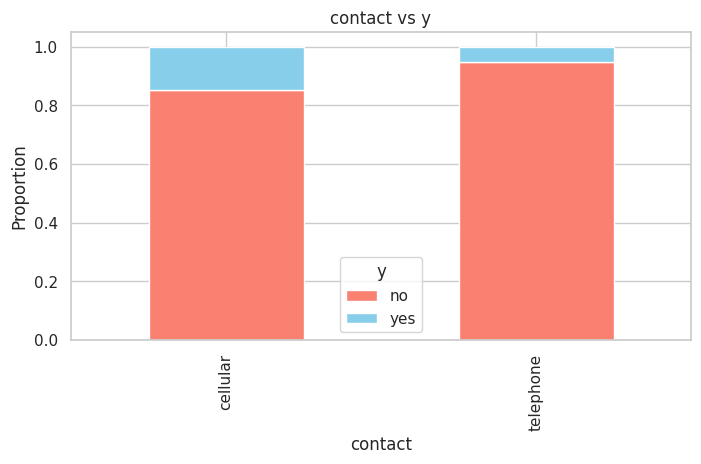

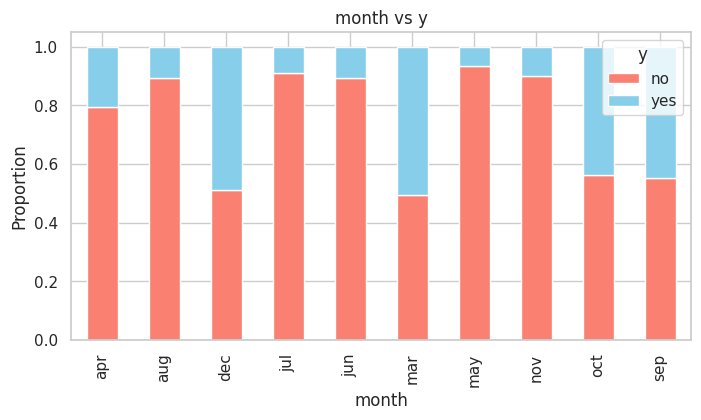

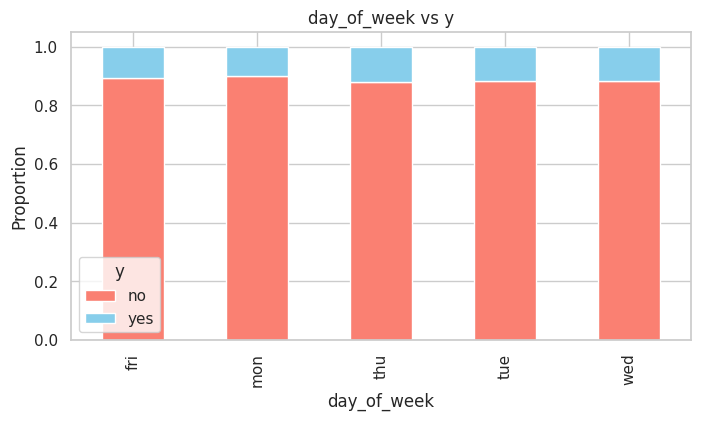

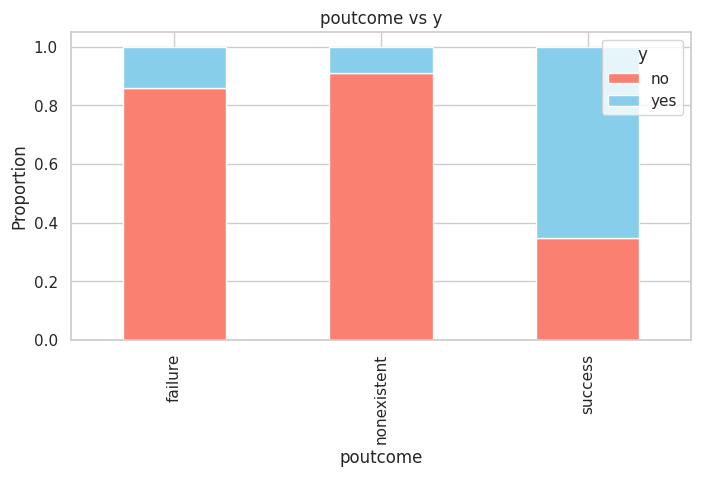

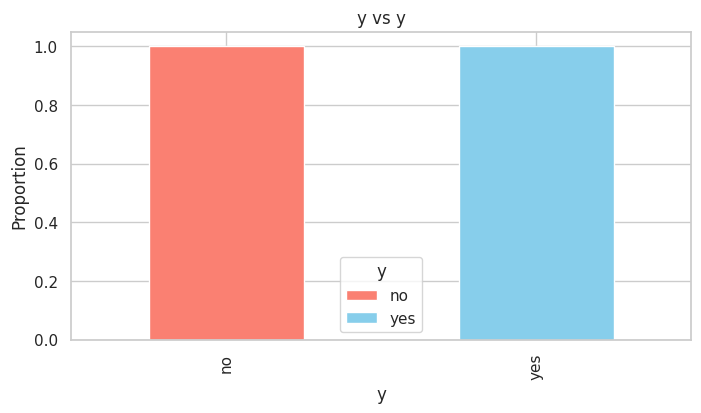

In [ ]:
df.sort_values(by='month', ascending=True, inplace=True)

for col in categorical_variables.columns:
    crosstab = pd.crosstab(df[col], df['y'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))
    plt.title(f"{col} vs y")
    plt.xlabel(col)
    plt.ylabel("Proportion")
    plt.legend(title='y')
    plt.show()

In [ ]:
stat_significant_cat_variables = []

for col in categorical_variables.columns:
    contingency_table = pd.crosstab(df[col], df['y'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"{col} vs y: Chi-square test p-value = {p}")
    if p < 0.05 and col != 'y':
      stat_significant_cat_variables.append(col)
print(stat_significant_cat_variables)

job vs y: Chi-square test p-value = 4.189763287563623e-199
marital vs y: Chi-square test p-value = 2.068014648442211e-26
education vs y: Chi-square test p-value = 3.3051890144025054e-38
default vs y: Chi-square test p-value = 5.1619579513916376e-89
housing vs y: Chi-square test p-value = 0.05829447669453452
loan vs y: Chi-square test p-value = 0.5786752870441754
contact vs y: Chi-square test p-value = 1.5259856523129964e-189
month vs y: Chi-square test p-value = 0.0
day_of_week vs y: Chi-square test p-value = 2.9584820052785324e-05
poutcome vs y: Chi-square test p-value = 0.0
y vs y: Chi-square test p-value = 0.0
['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome']


**We can see from the charts and test that some categorical variables are highly correlated with the outcome. The best example of this is "poutcome", if previous outcome was "success", it's highly likely that customer will subscribe again**

# DP

In [ ]:
# df.drop(columns=['duration_minutes'], inplace=True)
df.head()

age          job   marital    education  default housing loan  \
28035   28  blue-collar    single  high.school       no      no  yes   
29549   36   technician   married  high.school       no      no   no   
29550   38  blue-collar  divorced     basic.6y       no     yes  yes   
29551   35  blue-collar   married  high.school  unknown     yes   no   
29552   36   technician   married  high.school       no      no   no   

        contact month day_of_week  ...  previous     poutcome  emp.var.rate  \
28035  cellular   apr         thu  ...         1      failure          -1.8   
29549  cellular   apr         mon  ...         0  nonexistent          -1.8   
29550  cellular   apr         mon  ...         1      failure          -1.8   
29551  cellular   apr         mon  ...         0  nonexistent          -1.8   
29552  cellular   apr         mon  ...         0  nonexistent          -1.8   

       cons.price.idx cons.conf.idx  euribor3m  nr.employed   y  y_numeric  \
28035          93.075         -47.1      1.483       5099.1  no          0   
29549          93.075         -47.1      1.405       5099.1  no          0   
29550          93.075         -47.1      1.405       5099.1  no          0   
29551          93.075         -47.1      1.405       5099.1  no          0   
29552          93.075         -47.1      1.405       5099.1  no          0   

       log_duration  
28035      5.811141  
29549      5.337538  
29550      3.637586  
29551      2.995732  
29552      6.249975  

[5 rows x 23 columns]

One of the first things we do is to deal with pdays' 999s. It consists absolute majority of the existing pdays variable and makes that variable itself useless, however we can use it to create new categorical variable "pcampaign"

In [ ]:
augmented_df = df.copy()
augmented_df['pcampaign'] = np.where(df['pdays'] == 999, 'no', 'yes')
print(augmented_df.pcampaign.value_counts())
augmented_df.head()

pcampaign
no     39673
yes     1515
Name: count, dtype: int64


age          job   marital    education  default housing loan  \
28035   28  blue-collar    single  high.school       no      no  yes   
29549   36   technician   married  high.school       no      no   no   
29550   38  blue-collar  divorced     basic.6y       no     yes  yes   
29551   35  blue-collar   married  high.school  unknown     yes   no   
29552   36   technician   married  high.school       no      no   no   

        contact month day_of_week  ...     poutcome  emp.var.rate  \
28035  cellular   apr         thu  ...      failure          -1.8   
29549  cellular   apr         mon  ...  nonexistent          -1.8   
29550  cellular   apr         mon  ...      failure          -1.8   
29551  cellular   apr         mon  ...  nonexistent          -1.8   
29552  cellular   apr         mon  ...  nonexistent          -1.8   

       cons.price.idx  cons.conf.idx euribor3m  nr.employed   y  y_numeric  \
28035          93.075          -47.1     1.483       5099.1  no          0   
29549          93.075          -47.1     1.405       5099.1  no          0   
29550          93.075          -47.1     1.405       5099.1  no          0   
29551          93.075          -47.1     1.405       5099.1  no          0   
29552          93.075          -47.1     1.405       5099.1  no          0   

       log_duration  pcampaign  
28035      5.811141         no  
29549      5.337538         no  
29550      3.637586         no  
29551      2.995732         no  
29552      6.249975         no  

[5 rows x 24 columns]

let's now check if pcampaign and our target are correlated, i will use different methods below

In [ ]:
augmented_df['pcampaign_encoded'] = le.fit_transform(augmented_df['pcampaign'])
print(stats.pointbiserialr(augmented_df['pcampaign_encoded'], augmented_df['y_numeric']))

SignificanceResult(statistic=0.32487669778984035, pvalue=0.0)


<ipython-input-44-8e3b6774070c>:2: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  print(stats.pointbiserialr(augmented_df['pcampaign_encoded'], augmented_df['y_numeric']))


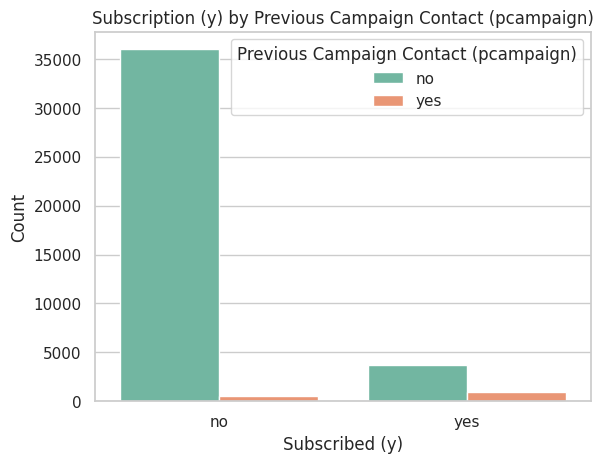

In [ ]:
# Calculate proportions or counts for each combination of 'y' and 'pcampaign'
proportions = augmented_df.groupby(['y', 'pcampaign']).size().reset_index(name='count')

# Plotting the grouped bar chart
sns.barplot(x='y', y='count', hue='pcampaign', data=proportions, palette='Set2')

# Add titles and labels
plt.title('Subscription (y) by Previous Campaign Contact (pcampaign)')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.legend(title='Previous Campaign Contact (pcampaign)')
plt.show()


In [ ]:
cross_table = pd.crosstab(augmented_df['y'], augmented_df['pcampaign'])

In [ ]:
cramer_v_result = cramer_v(cross_table)

print(f"Overall Cramer's V: {cramer_v_result}")


Overall Cramer's V: 0.32467271380455187


So there is a moderate correlation between contacts during previous campaign and our target. We can now drop the 'pdays' column, since its useless otherwise.
We can also drop duration, since we already have a log version of it. And categorical target variable, sinc we already transformed it. Same for pcampaign.

In [ ]:
augmented_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'y_numeric',
       'log_duration', 'pcampaign', 'pcampaign_encoded'],
      dtype='object')

In [ ]:
augmented_df.drop(columns=['pdays', 'duration', 'y', 'pcampaign'], inplace=True)
augmented_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y_numeric', 'log_duration', 'pcampaign_encoded'],
      dtype='object')

In [ ]:
numeric_variables.head()

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  y_numeric  
0          -36.4      4.857       5191.0          0  
1          -36.4      4.857       5191.0          0  
2          -36.4      4.857       5191.0          0  
3          -36.4      4.857       5191.0          0  
4          -36.4      4.857       5191.0          0

It's time to deal with outliers in our data

In [ ]:
# let's use our custom function
cap_outliers_iqr(augmented_df, 'campaign')

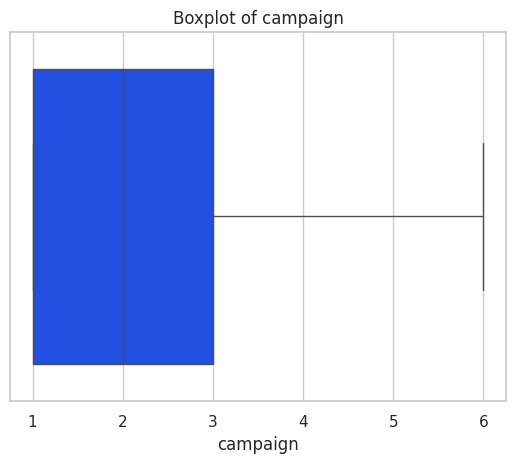

In [ ]:
sns.boxplot(x='campaign', data=augmented_df)
plt.title('Boxplot of campaign')
plt.show()

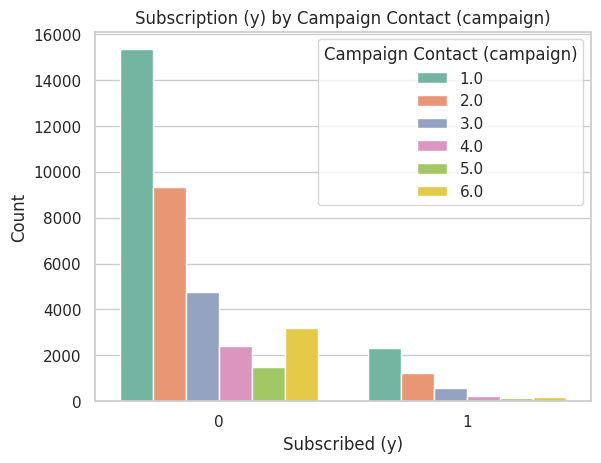

In [ ]:
# Calculate proportions or counts for each combination of 'y' and 'campaign'
proportions = augmented_df.groupby(['y_numeric', 'campaign']).size().reset_index(name='count')

sns.barplot(x='y_numeric', y='count', hue='campaign', data=proportions, palette='Set2')

plt.title('Subscription (y) by Campaign Contact (campaign)')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.legend(title='Campaign Contact (campaign)')
plt.show()

In [ ]:
augmented_df.dtypes

age                    int64
job                   object
marital               object
education             object
default               object
housing               object
loan                  object
contact               object
month                 object
day_of_week           object
campaign             float64
previous               int64
poutcome              object
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
y_numeric              int64
log_duration         float64
pcampaign_encoded      int64
dtype: object

# Dimensionality Reduction

In [ ]:
# change name of target according to best standards
augmented_df['y_encoded'] = augmented_df['y_numeric']
augmented_df.drop(columns=['y_numeric'], inplace=True)
augmented_df.head()

age          job   marital    education  default housing loan  \
28035   28  blue-collar    single  high.school       no      no  yes   
29549   36   technician   married  high.school       no      no   no   
29550   38  blue-collar  divorced     basic.6y       no     yes  yes   
29551   35  blue-collar   married  high.school  unknown     yes   no   
29552   36   technician   married  high.school       no      no   no   

        contact month day_of_week  ...  previous     poutcome emp.var.rate  \
28035  cellular   apr         thu  ...         1      failure         -1.8   
29549  cellular   apr         mon  ...         0  nonexistent         -1.8   
29550  cellular   apr         mon  ...         1      failure         -1.8   
29551  cellular   apr         mon  ...         0  nonexistent         -1.8   
29552  cellular   apr         mon  ...         0  nonexistent         -1.8   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  log_duration  \
28035          93.075          -47.1      1.483       5099.1      5.811141   
29549          93.075          -47.1      1.405       5099.1      5.337538   
29550          93.075          -47.1      1.405       5099.1      3.637586   
29551          93.075          -47.1      1.405       5099.1      2.995732   
29552          93.075          -47.1      1.405       5099.1      6.249975   

       pcampaign_encoded  y_encoded  
28035                  0          0  
29549                  0          0  
29550                  0          0  
29551                  0          0  
29552                  0          0  

[5 rows x 21 columns]

In [ ]:
numeric_variables = augmented_df.select_dtypes(['int64', 'float64'])
numeric_variables.head()

age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
28035   28       1.0         1          -1.8          93.075          -47.1   
29549   36       1.0         0          -1.8          93.075          -47.1   
29550   38       1.0         1          -1.8          93.075          -47.1   
29551   35       5.0         0          -1.8          93.075          -47.1   
29552   36       1.0         0          -1.8          93.075          -47.1   

       euribor3m  nr.employed  log_duration  pcampaign_encoded  y_encoded  
28035      1.483       5099.1      5.811141                  0          0  
29549      1.405       5099.1      5.337538                  0          0  
29550      1.405       5099.1      3.637586                  0          0  
29551      1.405       5099.1      2.995732                  0          0  
29552      1.405       5099.1      6.249975                  0          0

### PCA

In [ ]:
pca = PCA()
reduced = pca.fit_transform(numeric_variables)

In [ ]:
pca.explained_variance_ratio_

array([9.74949243e-01, 2.03420380e-02, 3.89565290e-03, 4.44342071e-04,
       1.58057798e-04, 1.43236568e-04, 3.54227420e-05, 1.40750386e-05,
       7.57380950e-06, 6.65171182e-06, 3.70626416e-06])

Let's standardize our data beforehand

In [ ]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(numeric_variables)

# Then apply PCA
pca = PCA()
reduced = pca.fit_transform(df_standardized)
explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.36810807 0.13805696 0.10653845 0.09744595 0.08500406 0.07792852
 0.05271457 0.03774495 0.03323751 0.0022599  0.00096107]


**Although, it is expected for PCA to standardize data by default, seems like we get very different results before and after standardization. Therefore, because standardization is generally a good practice, I will stick with the PCA after standardization, as it definitely improves the results. Intuitively too, for example nr.employed had values in thousands while other variables were given in a different scale, so for me it seems bias was created towards the variable with the higher scale.**

Let us now create the variance threshold chart. We are interested to see, according to best practice, how many components explain 95% variance in the data.

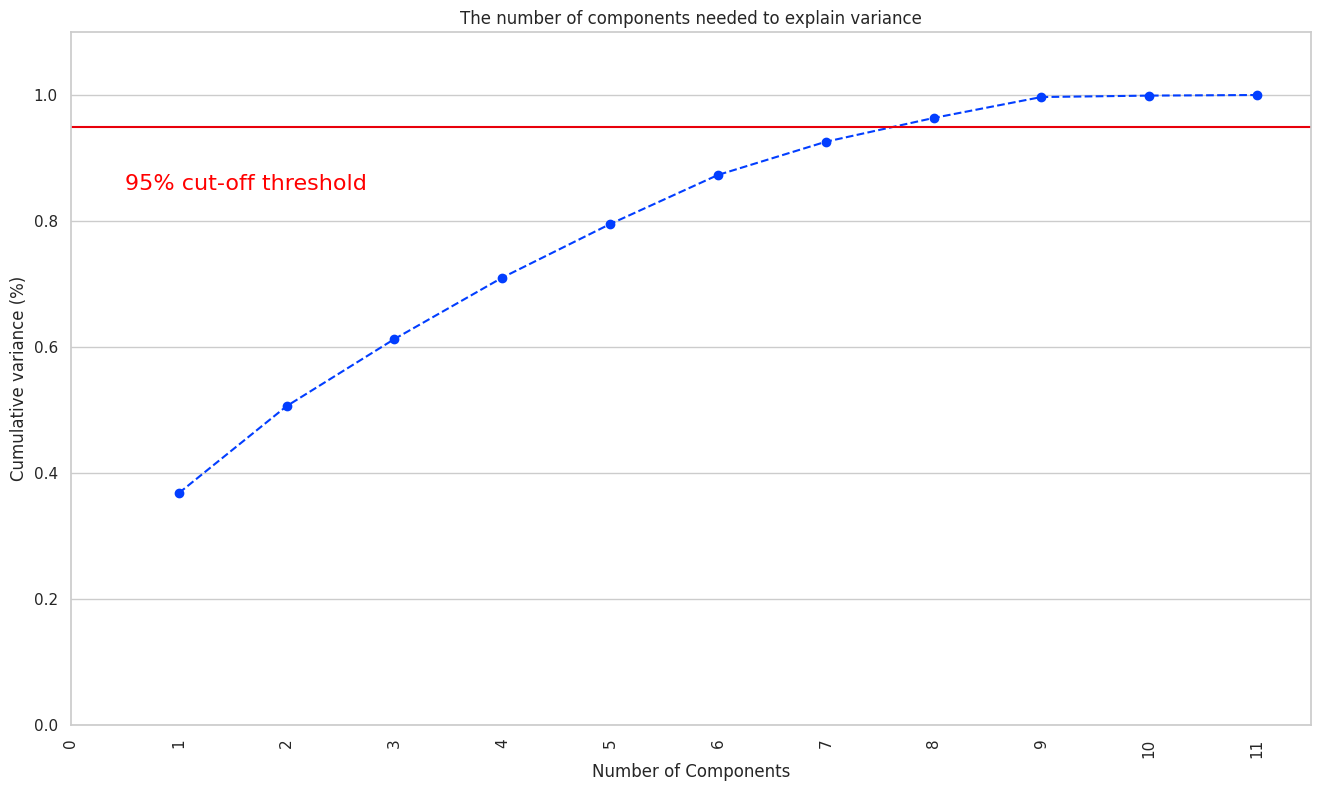

In [ ]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(16, 9))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker="o", linestyle="--", color="b")

plt.xlabel("Number of Components")
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel("Cumulative variance (%)")
plt.title("The number of components needed to explain variance")

plt.axhline(y=0.95, color="r", linestyle="-")
plt.text(0.5, 0.85, "95% cut-off threshold", color = "red", fontsize=16)

ax.grid(axis="x")
plt.xticks(rotation=90)
plt.show()

**As suggested by PCA, we need 8 components to expain 95% variance in the data**

In [ ]:
# abs of components
loadings = np.abs(pca.components_)

feature_names = numeric_variables.columns

# loadings df
loadings_df = pd.DataFrame(
    loadings.T,
    columns=[f'PC{i+1}' for i in range(loadings.shape[0])],
    index=feature_names
)

weighted_loadings = loadings_df.multiply(explained_variance_ratio, axis=1).sum(axis=1)
feature_importance = weighted_loadings.sort_values(ascending=False)
print("Features ranked by importance:")
print(feature_importance)

# these should be least important features
least_important = feature_importance.tail(3).index.tolist()
print(least_important)

Features ranked by importance:
previous             0.282669
cons.price.idx       0.273090
y_encoded            0.266805
pcampaign_encoded    0.263230
emp.var.rate         0.231500
cons.conf.idx        0.226969
euribor3m            0.224473
log_duration         0.222284
nr.employed          0.218775
campaign             0.210908
age                  0.180705
dtype: float64

Least important features that could be dropped:
['nr.employed', 'campaign', 'age']


**It was also interesting to see the weights in components**

In [ ]:
numeric_variables.columns

Index(['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'log_duration',
       'pcampaign_encoded', 'y_encoded'],
      dtype='object')

## t-SNE

**Finally, we can use PCA finding as our foundation and use t-sne to visualize results**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


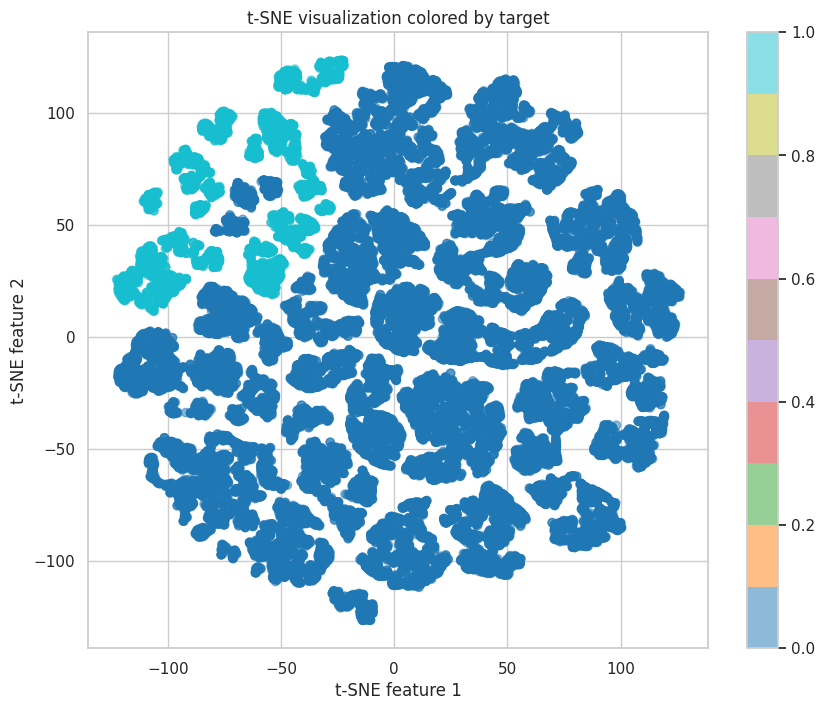

In [ ]:
# use our PCA result
pca_before_tsne = PCA(n_components=8)
data_pca_reduced = pca_before_tsne.fit_transform(df_standardized)

# apply t-SNE
tsne = TSNE(
   n_components=2,
   perplexity=30,
   n_iter=1000,
   random_state=42,
   init='pca'
)

tsne_results = tsne.fit_transform(data_pca_reduced)

# visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                    c=numeric_variables['y_encoded'],
                    cmap='tab10',
                    alpha=0.5)
plt.title('t-SNE visualization colored by target')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(scatter)
plt.show()

**Let's see how the results would look like with smaller perplexity**

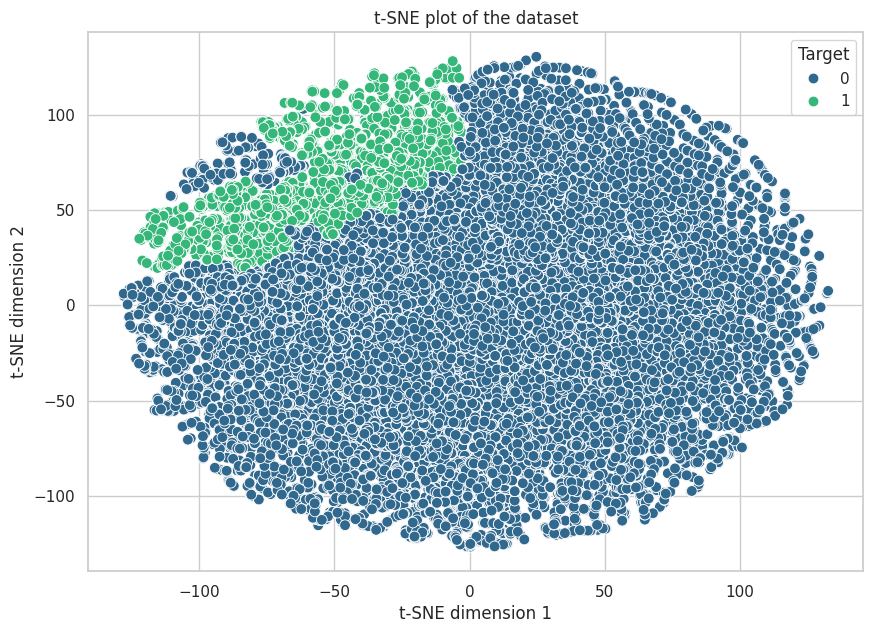

In [ ]:
tsne = TSNE(random_state=0, perplexity=5)
tsne_results = tsne.fit_transform(df_standardized)
target = augmented_df['y_encoded']  # Use 'y' variable for coloring, assuming you have a binary target
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=target, palette='viridis', s=60)
plt.title("t-SNE plot of the dataset")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="Target")
plt.show()

**As expected, we got the better results with perplexity=30.**

# Conclusion

Finally, we can see that samples with similar target values of 1(same as "yes"- that is whether customer subscribed to the banking product in the current campaign) share similar characteristics. We can see that samples with same target values are localized in left-upper part of the chart. This distribution is certainly non-random and tells us that our selected features are important in terms of making predictions about our target. Moreover, this clear separation between target values also suggests that my earlier decision with number of components after PCA was correct.

Results are also in line with domain knowledge of what plays an important role to make a successful sale of a banking product. For further exploration of this topic other techniques like regression could be helpful.